## Simple Autoencoders and Variational Autoencoders

This exercise will guide you through creating a regular autoencoder and a variational one. We'll also sample from the learned latent spaces to illustrate how much better variational autoencoders are at generative modeling. Along the way, we'll visualize the latent space produced by each of the autoencoders to get an idea of what's happening behind the scenes.

To start, we'll create a simple autoencoder. Fill in the TODOs. The cell below just imports the necessary modules and takes care of device placement.

In [2]:
import os
import torch
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as tvtransforms
import torchvision.utils as vutils
from torch.utils.data import TensorDataset
import numpy as np

img_shape = (1, 28, 28)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64

In [0]:
class Autoencoder(nn.Module):

    def __init__(self, latent_size):
        # One of the arguments in the constructor is latent_size, which
        # indicates how many nodes you want to downsample the input to.
        # Recall the encoding portion of AE reduces dimensionality of the input

        super(Autoencoder, self).__init__()
        self.latent_size = latent_size
        # We'll be working with MNIST, so the input dimension will be 784.
        self.encoder1 = nn.Linear(784, 512)
        # TODO: Create two more encoding layers that successively downscale the input
        self.encoder2 = ???
        self.encoder3 = ???
        
        # reduced dimensionality of input (final encoding)
        self.bottleneck = nn.Linear(128, latent_size)

        # decoding portion of AE, take encoded data and decode to original dimensionality
        self.decoder1 = nn.Linear(latent_size, 128)
        self.decoder2 = nn.Linear(128, 256)
        self.decoder3 = nn.Linear(256, 512)
        # output original dimensionality (784 in the case of MNIST)
        self.out = nn.Linear(512, 784)
    
    def encode(self, x):
        enc1 = F.relu(self.encoder1(x))
        enc2 = F.relu(self.encoder2(enc1))
        enc3 = F.relu(self.encoder3(enc2))
        encoded_representation = self.bottleneck(enc3)
        return encoded_representation
    
    def decode(self, x):
        dec1 = F.relu(self.decoder1(x))
        dec2 = F.relu(self.decoder2(dec1))
        dec3 = F.relu(self.decoder3(dec2))
        out = self.out(dec3)
        return out
        
    def forward(self, x):
        # forward mode, pass input through activation funtions
        # Simple!
        decoded = self.decode(self.encode(x))
        return decoded
        

## Read in MNIST Data
We'll use these loaders for training and testing our autoencoders.

In [0]:
batch_size = 64
os.makedirs("data/mnist", exist_ok=True)
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "data/mnist",
        train=True,
        download=True,
        transform=tvtransforms.Compose(
            [tvtransforms.ToTensor()]
        ),
    ),
    batch_size=batch_size,
    drop_last=True,
    num_workers=2,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "data/mnist",
        train=False,
        download=True,
        transform=tvtransforms.Compose(
            [tvtransforms.ToTensor()]
        ),
    ),
    batch_size=batch_size,
    drop_last=True,
    num_workers=2,
    shuffle=True,
)

In [1]:
lr = .001
epochs = 5
latent_size = 20 # Size of the bottleneck layer
ae = Autoencoder(latent_size).to(device)
ae_optimizer = optim.Adam(model.parameters(), lr=lr)
# TODO: what should the loss function be here for real-valued outputs?
criterion = ??? 
for epoch in range(1, epochs + 1):
     for data, _ in train_loader:
         optimizer.zero_grad()
         data = data.view(-1, 28*28) # Reshape the MNIST image to batch_size x 784
         output = ae.forward(data)
         loss = criterion(output, data)
         loss.backward()
         optimizer.step()
     print('Epoch: {}/{}.............{}'.format(epoch, epochs, loss.item()), end='\n')

NameError: name 'Autoencoder' is not defined

Now that we have a trained autoencoder, lets sample from the latent space and generate new images. Remember the idea with generative modeling is to produce samples that are likely under the training set. In this case, samples from our autoencoder should resemble MNIST digits. To do this, we'll draw random samples from a normal distribution and pass it through the decoding section of the autoencoder. 

In [ ]:
latent_sample = torch.randn(16, latent_size) # 16 instances of vectors of size latent_size drawn from a normal.

with torch.no_grad():
    
    decoded_digits = ae.??? # What should go here?

    decoded_digits = decoded_digits.detach().cpu().view(-1, 28, 28) # Reshape into images.

ae_grid = vutils.make_grid(decoded_digits, nrow=4)
ae_grid = ae_grid.permute(1, 2, 0)
plt.figure(figsize=(13, 10))
plt.imshow(ae_grid)

What's going on here? The decoded digits look bad. We can't sample easily from the latent space of the regular autoencoder because we don't know where to look in this high-dimensional latent space. You can get lucky and actually produce real looking digits, but in a large-dimensional latent space this becomes pretty hard. The solution to this is to use a variational autoencoder.

## Variational Autoencoder

![On the left is the regular autoencoder and on the right the variational one.](vae.png)

The figure above shows a regular autoencoder on the left and a variational autoencoder on the right. The variational autoencoder learns the variance and the mean of a normal distribution that we sample from to generate images. The regular autoencoder just learns an arbitrary encoded representation. Something that I missed when reading the paper is that the layer that outputs the variance should actually be interpreted as generating the log(variance). Keep this in mind when implementing the class below.

In [ ]:
class VAE(nn.Module):
    
    def __init__(self, latent_size):
        super(VAE, self).__init__()
        # Since you already coded the fully connected layers for the autoencoder, we won't
        # make you do it again.
        self.latent_size = latent_size
        self.activation = F.relu
        self.efc1 = nn.Linear(784, 256)
        self.efc2 = nn.Linear(256, 128)
        self.efc3 = nn.Linear(128, 64)
        
        # TODO: what is the bottleneck layer in the variational autoencoder supposed
        # to output? Refer to the figure above. 
        self.??? = 
        self.??? = 

        # TODO: copy decoding code from your autoencoder class
        self.dfc1 = nn.Linear(latent_size, 256)
        self.dfc2 = nn.Linear(256, 512)
        self.dfc3 = nn.Linear(512, 784)
    
    def encode(self, x):
        x = self.efc1(x)
        x = self.activation(x)
        x = self.efc2(x)
        x = self.activation(x)
        x = self.efc3(x)
        x = self.activation(x)
        # TODO: We're learning mean and variance vectors in the encoding step.
        # What layers should go here?
        return ???
    
    
    def decode(self, z):
        x = self.dfc1(z)
        x = self.activation(x)
        x = self.dfc2(x)
        x = self.activation(x)
        x = self.dfc3(x)
        # The VAE seems to do a lot better on MNIST if we end the decoding 
        # step with a sigmoid and use binary cross entropy.
        return torch.sigmoid(x)
    
    def sample(self, logvariance, mu):
        # TODO: how do you sample from the learned 
        # normal distribution? This is where the authors introduce the
        # reparameterization trick (shown in the image below).
        # The function torch.randn(dim0, dim1, ...) will be useful.
        return z_sample
        
    def forward(self, x):
        # TODO: create log(variance) and mean vectors with the encoder.
        ???
        # TODO: sample from the normal distribution described by the mean and variance vectors.
        # This is where the authors use the reparameterization trick.
        ???
        # TODO: Reconstruct the image from the sampled latent vector.
        ???
        # Return the logvariance, mean, and reconstructed image for computing the loss.
        return ???, ???, ???


## The reparameterization trick 
![](reparam.png)

We want to sample from the normal distribution whose mean and variance we learn. 
$$z = \mu + \sigma*\epsilon,$$ where epsilon is drawn from $\mathcal{N}(0, I)$. In our case, we're sampling from a N-dimensional normal distribution, but the formula stays the same.


# KL Divergence
Now we have to implement the KL divergence part of the loss function. The authors of the original paper say that
$$D_{KL} = -\frac{1}{2}*\sum_j(1 + log(\sigma_j^2) - \mu_j^2 - \sigma_j^2).$$

The derivative will be taken care of by autodiff.

In [ ]:
def closed_form_kl_div(mu, logvariance):
    # TODO: implement closed form KL divergence.
    return ???

In [1]:
vae = VAE(latent_size).to(device)
opt_vae = torch.optim.Adam(vae.parameters(), lr=lr)
epochs = 5
for epoch in range(epochs):
    print('epoch', epoch+1)
    for i, (real_imgs, _) in enumerate(train_loader, 0):
        
        real_imgs = real_imgs.to(device)

        real_imgs = real_imgs.view(-1, 28*28)
        vae.zero_grad()
        
        # TODO: Fill in return values that will be used to calculate the loss.
        _, _, _ = vae.forward(real_imgs)
        
        # TODO: calculate the KL divergence.
        kl_div = ???
        # The VAE does a lot better if we use BCE
        BCE = F.binary_cross_entropy(reconstructed_image_vae, real_imgs, reduction='sum')
        # TODO: What should the total loss funcion be?
        loss_vae = ???
        
        loss_vae.backward()
        opt_vae.step()
    print('Epoch: {}/{}.............{}'.format(epoch, epochs, loss_vae.item()), end='\n')
    

SyntaxError: invalid syntax (<ipython-input-1-18a60cb121fa>, line 17)

torch.Size([3, 242, 242])


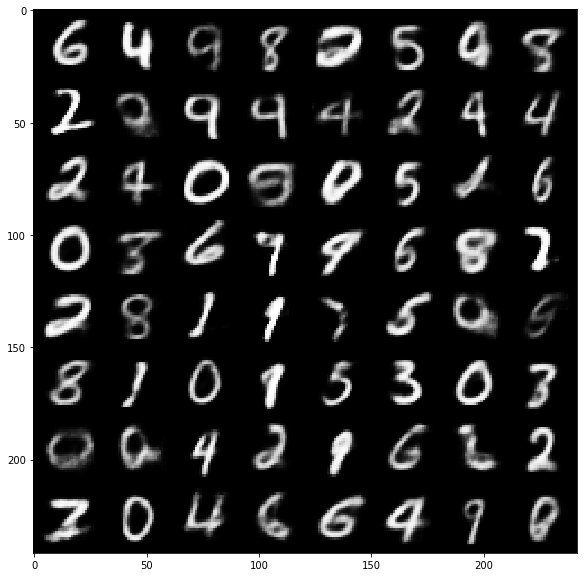

In [0]:
normal_z = torch.randn(batch_size, latent_size).to(device)
with torch.no_grad():
    out_vae = vae.decode(normal_z).cpu().detach()
    out_vae = out_vae.view(-1, 1, 28, 28)
    out_ae = ae.decode(normal_z).cpu().detach()
    out_ae = out_ae.view(-1, 1, 28, 28)

vae_grid = vutils.make_grid(out_vae, nrow=8)
ae_grid = vutils.make_grid(out_ae, nrow=8)
vae_grid = vae_grid.permute(1, 2, 0)
ae_grid = ae_grid.permute(1, 2, 0)
fig, ax = plt.subplots(ncols=2, figsize=(13, 10))
ax[0].imshow(vae_grid)
ax[1].imshow(ae_grid)
ax[0].set_title("vae samples")
ax[1].set_title("ae samples")

The samples drawn from the VAE should look much better. Another way we can inspect the results is to visualize the latent space of both of the autoencoders. To do this, we'll use a dimensionality reduction technique called TSNE. We'll use the test set to do this.

In [ ]:

latent_reps_ae = np.zeros((batch_size*len(test_loader), latent_size)) 
# instances (batch_size * n_test) by latent_dim
latent_reps_vae = np.zeros((batch_size*len(test_loader), latent_size)) 
labels = np.zeros((batch_size*len(test_loader)))

for i, (real_img, label)  in enumerate(test_loader):
    with torch.no_grad():
        real_img = real_img.to(device)
        real_img = real_img.view(-1, 28*28)
        
        ae_encoded = ae.encode(real_img).detach().cpu()
        # TODO: How do you sample from the vae's latent space? First you need to generate
        # log(variance) and mu, then sample from the normal dist. 
        ???, ??? = vae.encode(real_img)
        vae_encoded = ???
        
        latent_reps_ae[i*batch_size:i*batch_size+batch_size, :] = ae_encoded
        latent_reps_vae[i*batch_size:i*batch_size+batch_size, :] = z_sample
        labels[i*batch_size:i*batch_size+batch_size] = label.cpu()

In [ ]:
from sklearn.manifold import TSNE
# Here is where we do the latent space dimensionality compression down to two dimensions
vae_embed = TSNE(n_components=2).fit_transform(latent_reps_vae)
ae_embed = TSNE(n_components=2).fit_transform(latent_reps_ae)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(13, 11))
for i in range(10):
    ax[0].scatter(vae_embed[:, 0][labels==i], vae_embed[:, 1][labels==i], label=str(i))
    ax[1].scatter(ae_embed[:, 0][labels==i], ae_embed[:, 1][labels==i], label=str(i))

ax[0].legend()
ax[1].legend()

Further directions
1. What happens if you set the latent_size to 2? Can the regular autoencoder generate reasonable images? Why do you think this is? (Visualizing the latent space without a TNSE embedding gives some insight into this.)
